<a href="https://colab.research.google.com/github/SanjayAmaravadi/Employee-Salary-Prediction/blob/main/Employee_Salary_Prediction_Using_GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Employee Salary Prediction Using GradientBoosting**

In [34]:
#Importing the Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from xgboost import XGBClassifier

import gradio as gr
import pickle
import joblib

In [35]:
data = pd.read_csv('/content/adult 3.csv')

In [36]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [37]:
#replace the values in a column
data['workclass'] = data['workclass'].replace("?", "others")
data['occupation'] = data['occupation'].replace('?', 'others')
data['native-country'] = data['native-country'].replace('?', 'others')

In [38]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,others,103497,Some-college,10,Never-married,others,Own-child,White,Female,0,0,30,United-States,<=50K


In [39]:
#Removing the features
data = data.drop(columns=['relationship', 'education','fnlwgt','race'])

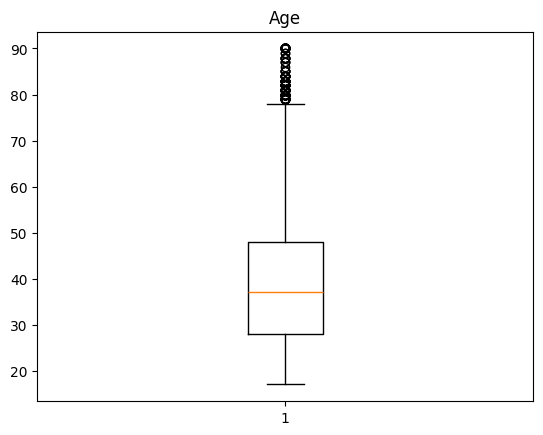

In [40]:
plt.boxplot(data['age'])
plt.title("Age")
plt.show()

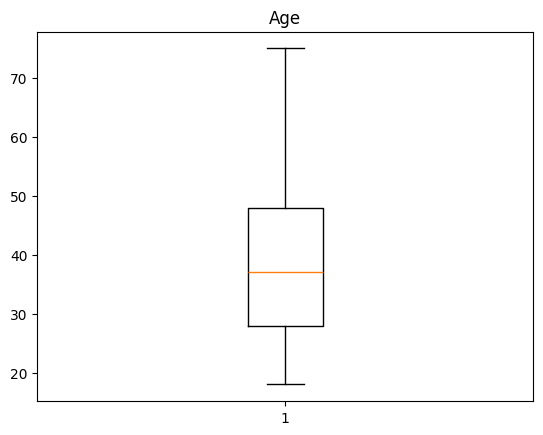

In [41]:
#Removing outlayer
data = data[ (data['age'] <= 75) & (data['age'] >= 18) ]

plt.boxplot(data['age'])
plt.title("Age")
plt.show()

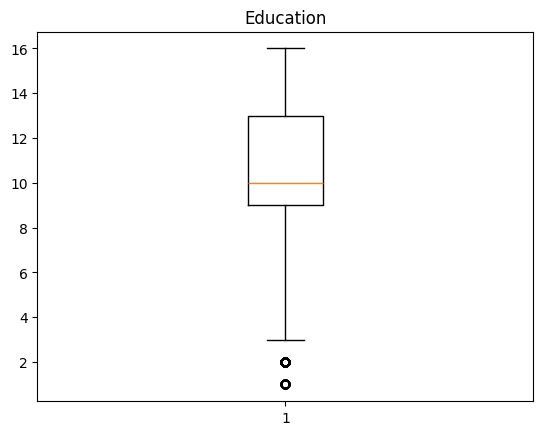

In [42]:
plt.boxplot(data['educational-num'])
plt.title('Education')
plt.show()

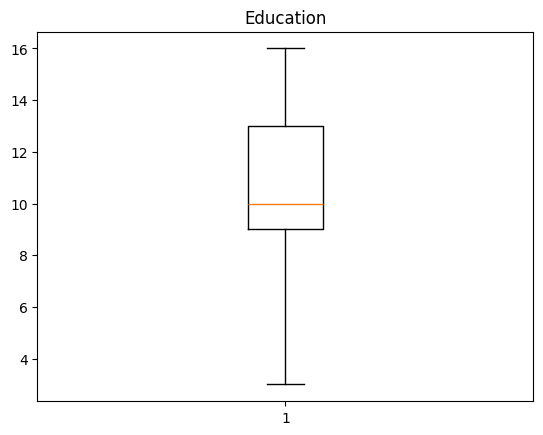

In [43]:
data = data[ data['educational-num'] >= 3 ]

plt.boxplot(data['educational-num'])
plt.title("Education")
plt.show()

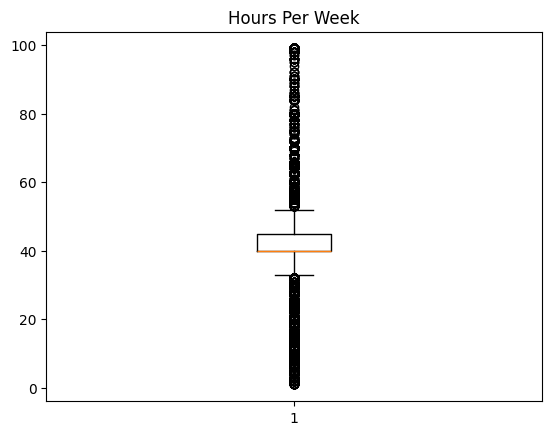

In [44]:
plt.boxplot(data['hours-per-week'])
plt.title('Hours Per Week')
plt.show()

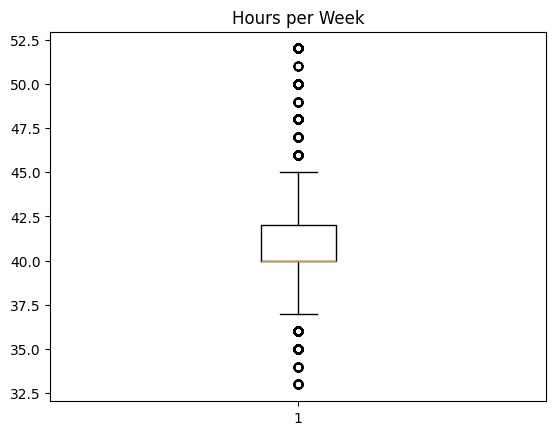

In [45]:
Q1 = data['hours-per-week'].quantile(0.25)
Q3 = data['hours-per-week'].quantile(0.75)
IQR = Q3 - Q1

# Calculate boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Removing outliers from data
data = data[ (data['hours-per-week'] >= lower_bound) & (data['hours-per-week'] <= upper_bound) ]

plt.boxplot(data['hours-per-week'])
plt.title("Hours per Week")
plt.show()

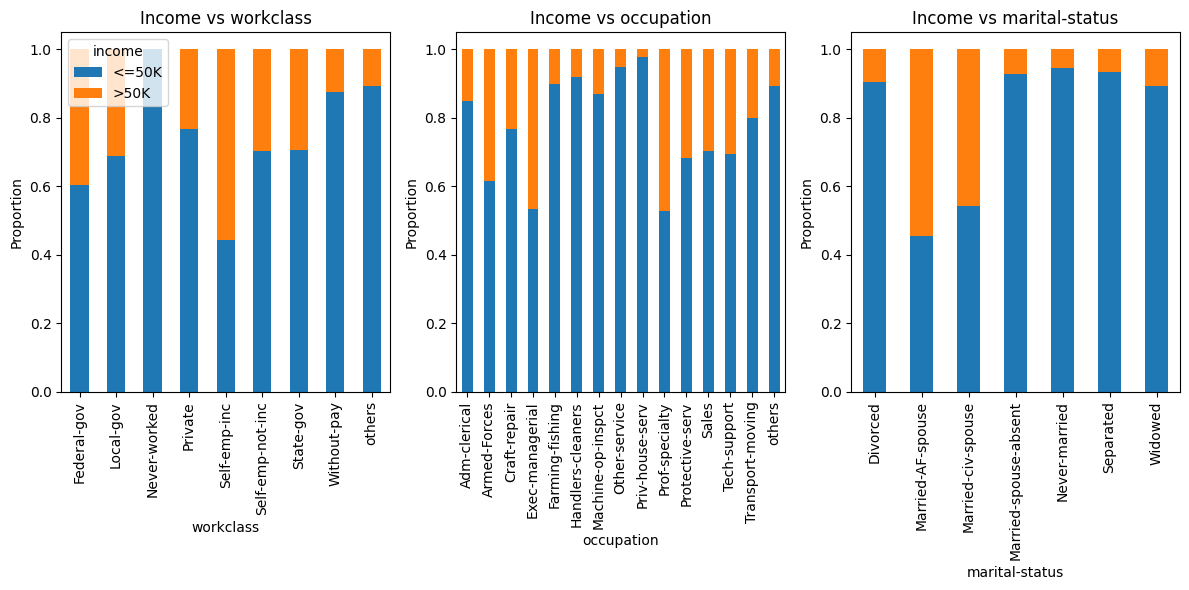

In [46]:
# Visuallization
features = ['workclass', 'occupation', 'marital-status']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each feature
for i, feature in enumerate(features):
    pd.crosstab(data[feature], data['income'], normalize='index') \
      .plot(kind='bar', stacked=True, ax=axes[i], legend=(i == 0))

    axes[i].set_title(f"Income vs {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Proportion")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [47]:
#Workclass
data = data[data['workclass'] != 'Without-pay']
data = data[data['workclass'] != 'Never-worked']
data['workclass'] = data['workclass'].replace(['Federal-gov', 'Local-gov', 'State-gov'], 'Government')

In [48]:
#Armed and Protected serivces
data['occupation'] = data['occupation'].replace(['Protective-serv', 'Armed-Forces'],'Protective & Armed Services')

In [49]:
#Marital-Status
data['marital-status'] = data['marital-status'].replace(['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
data['marital-status'] = data['marital-status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-spouse-absent'], 'No Patner')

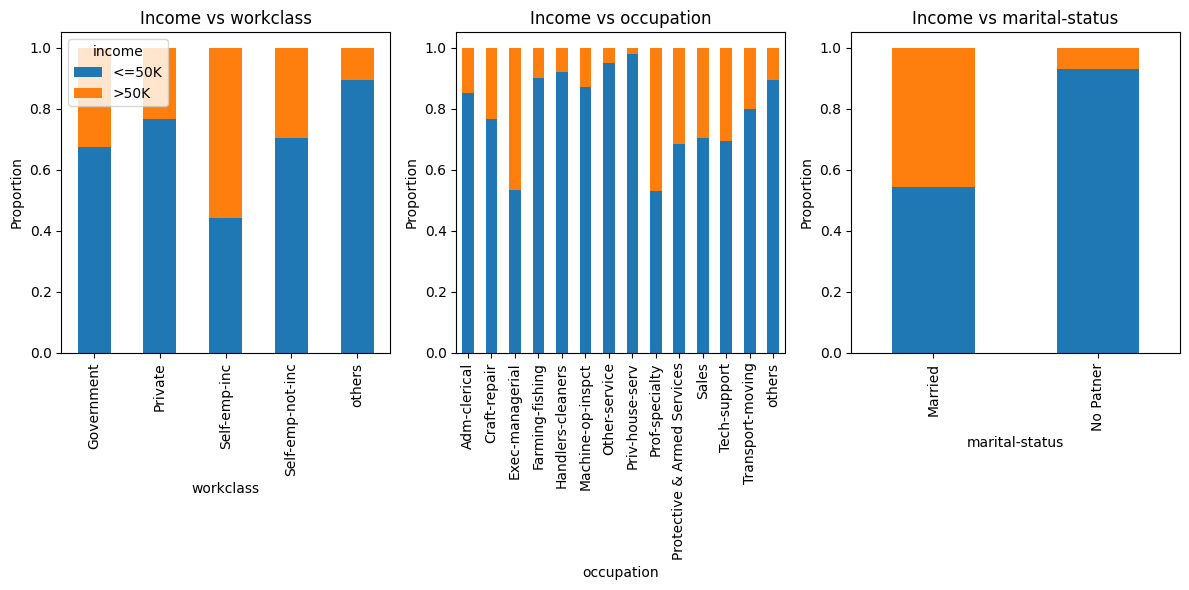

In [50]:
features = ['workclass', 'occupation', 'marital-status']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each feature
for i, feature in enumerate(features):
    pd.crosstab(data[feature], data['income'], normalize='index') \
      .plot(kind='bar', stacked=True, ax=axes[i], legend=(i == 0))

    axes[i].set_title(f"Income vs {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Proportion")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [51]:
#Encoding
cat_cols = ['workclass', 'marital-status', 'occupation', 'gender', 'native-country', 'income']
label_encoders = {}

# Encode each column separately
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Save encoders to use during prediction
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [52]:
data.head()

,age,workclass,educational-num,marital-status,occupation,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,1,7,1,5,1,0,0,40,38,0
1,38,1,9,0,3,1,0,0,50,38,0
2,28,0,12,0,9,1,0,0,40,38,1
3,44,1,10,0,5,1,7688,0,40,38,1
6,29,4,9,1,13,1,0,0,40,38,0


In [53]:
#spliting the data as input and output
x = data.drop(columns = ['income'])
y = data['income']

In [54]:
x.head()

,age,workclass,educational-num,marital-status,occupation,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,1,7,1,5,1,0,0,40,38
1,38,1,9,0,3,1,0,0,50,38
2,28,0,12,0,9,1,0,0,40,38
3,44,1,10,0,5,1,7688,0,40,38
6,29,4,9,1,13,1,0,0,40,38


In [55]:
y.head()

,income
0,0
1,0
2,1
3,1
6,0


Scalling (MinMax Scaller)

In [56]:
#Scaling the values in between 0 and 1
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [57]:
x

array([[0.12280702, 0.25      , 0.30769231, ..., 0.        , 0.36842105,
        0.92682927],
       [0.35087719, 0.25      , 0.46153846, ..., 0.        , 0.89473684,
        0.92682927],
       [0.1754386 , 0.        , 0.69230769, ..., 0.        , 0.36842105,
        0.92682927],
       ...,
       [0.38596491, 0.25      , 0.46153846, ..., 0.        , 0.36842105,
        0.92682927],
       [0.70175439, 0.25      , 0.46153846, ..., 0.        , 0.36842105,
        0.92682927],
       [0.59649123, 0.5       , 0.46153846, ..., 0.        , 0.36842105,
        0.92682927]])

Spliting the data as Training and Testing


In [58]:
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.2, random_state = 42, stratify = y)

In [59]:
# Calculate class imbalance weight
neg, pos = np.bincount(ytrain)
scale_pos_weight = neg / pos


KNN Accuracy: 0.8168
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5192
           1       0.66      0.60      0.62      1785

    accuracy                           0.82      6977
   macro avg       0.76      0.74      0.75      6977
weighted avg       0.81      0.82      0.81      6977



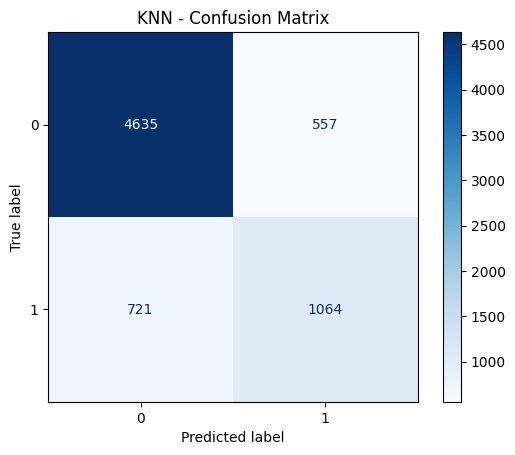


LogisticRegression Accuracy: 0.8336
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      5192
           1       0.72      0.57      0.64      1785

    accuracy                           0.83      6977
   macro avg       0.79      0.75      0.76      6977
weighted avg       0.83      0.83      0.83      6977



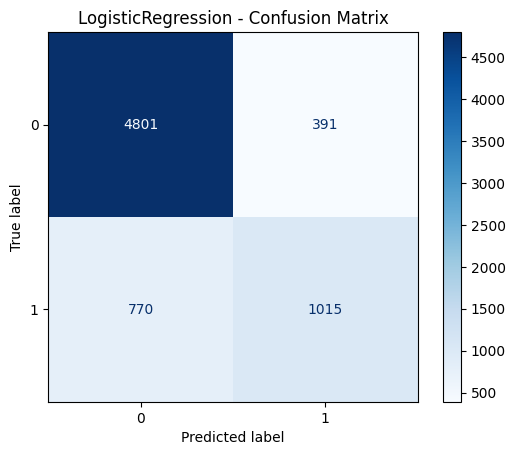


RandomForest Accuracy: 0.8302
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      5192
           1       0.68      0.62      0.65      1785

    accuracy                           0.83      6977
   macro avg       0.78      0.76      0.77      6977
weighted avg       0.83      0.83      0.83      6977



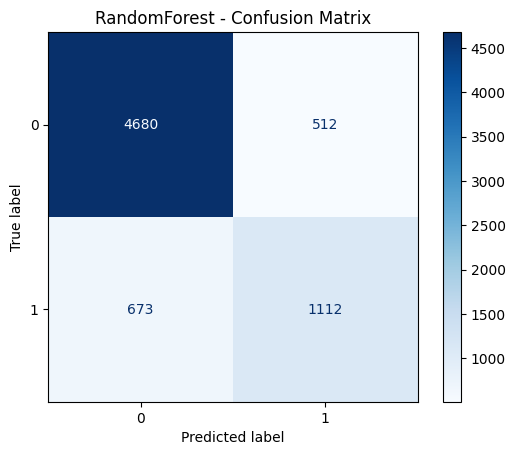


SVM Accuracy: 0.8393
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5192
           1       0.76      0.54      0.63      1785

    accuracy                           0.84      6977
   macro avg       0.81      0.74      0.77      6977
weighted avg       0.83      0.84      0.83      6977



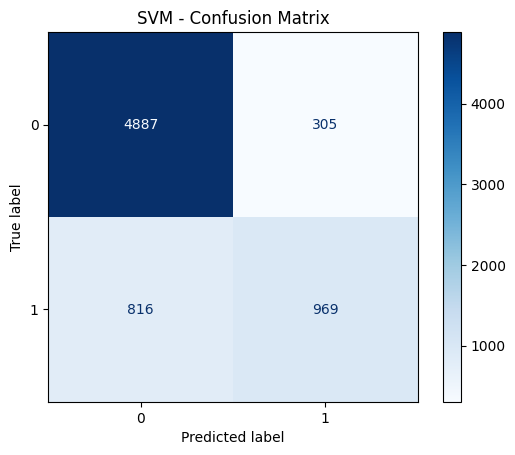


GradientBoosting Accuracy: 0.8555
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      5192
           1       0.76      0.64      0.69      1785

    accuracy                           0.86      6977
   macro avg       0.82      0.78      0.80      6977
weighted avg       0.85      0.86      0.85      6977



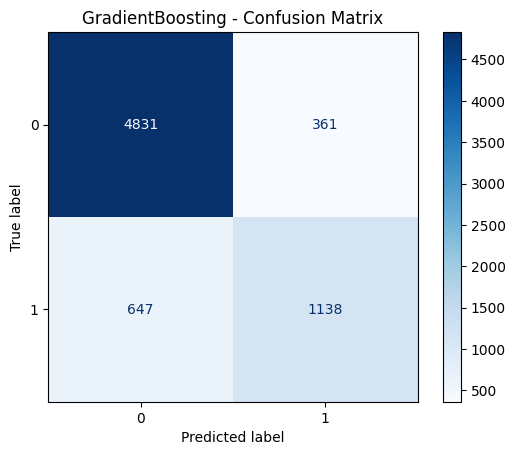

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:15:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Accuracy: 0.8181
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5192
           1       0.60      0.84      0.70      1785

    accuracy                           0.82      6977
   macro avg       0.77      0.82      0.79      6977
weighted avg       0.85      0.82      0.83      6977



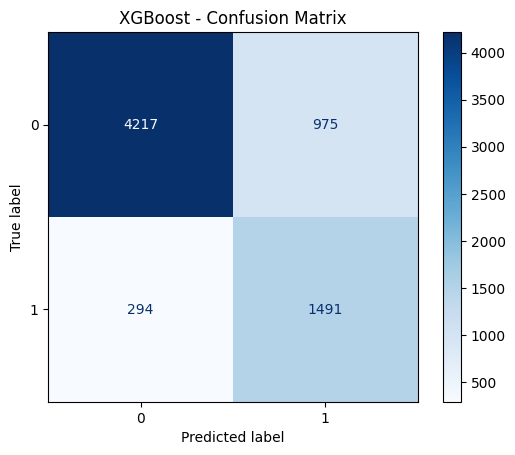

In [60]:
models = {
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
    )
}

results = {}


for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    pipe.fit(xtrain, ytrain)
    y_pred = pipe.predict(xtest)

    acc = accuracy_score(ytest, y_pred)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(ytest, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(ytest, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

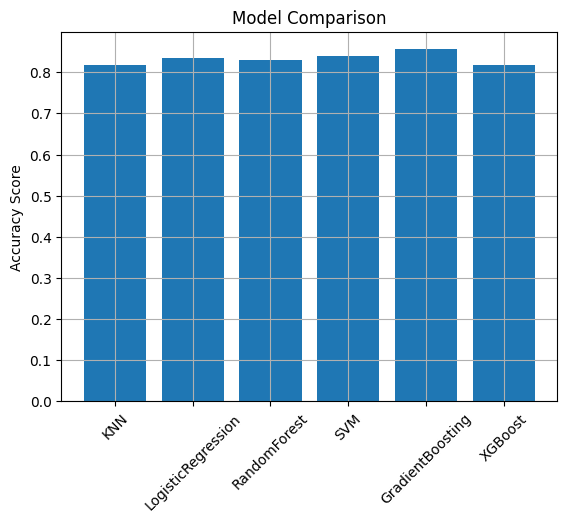

In [61]:
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy Score')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [62]:
# Get best model
for i in results:
  print(f"{i} : {results[i]}")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Save the best model
joblib.dump(best_model, "best_model.pkl")
print("Saved best model as best_model.pkl")

KNN : 0.8168267163537337
LogisticRegression : 0.8335961014762792
RandomForest : 0.8301562276049879
SVM : 0.8393292245950982
GradientBoosting : 0.8555252974057618
XGBoost : 0.818116669055468

Best model: GradientBoosting with accuracy 0.8555
Saved best model as best_model.pkl


In [64]:
# Load saved model and encoders
model = joblib.load("best_model.pkl")
with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

# Define prediction function
def predict_salary(age, workclass, educational_num, marital_status, occupation, gender,
                   capital_gain, capital_loss, hours_per_week, native_country):

    # Build input dataframe
    input_data = pd.DataFrame({
        'age': [age],
        'workclass': [workclass],
        'educational-num': [educational_num],
        'marital-status': [marital_status],
        'occupation': [occupation],
        'gender': [gender],
        'capital-gain': [capital_gain],
        'capital-loss': [capital_loss],
        'hours-per-week': [hours_per_week],
        'native-country': [native_country]
    })

    # Encode categorical fields
    for col in ['workclass', 'marital-status', 'occupation', 'gender', 'native-country']:
        encoder = label_encoders[col]
        try:
            input_data[col] = encoder.transform(input_data[col])
        except ValueError:
            return f"⚠️ Unknown category '{input_data[col][0]}' in column '{col}'"

    # Predict
    prediction = model.predict(input_data)[0]
    result = ">50K" if prediction == 1 else "≤50K"
    return f"Prediction: {result}"

# Define the Gradio UI
with gr.Blocks(
    title="Employee Salary Prediction",
    css=".orange-btn { background-color: orange !important; color: white !important; }"
    ) as demo:
    gr.Markdown("<h2 style='text-align: center;'>💼 Employee Salary Prediction App</h2>")

    with gr.Row():
        age = gr.Slider(18, 75, value=30, label="Age")
        educational_num = gr.Slider(1, 16, step=1, label="Educational-Num")
        hours_per_week = gr.Slider(30, 45, label="Hours per week")

    with gr.Row():
        workclass = gr.Dropdown(["Government", "Private", "Self-emp-not-inc", "Self-emp-inc", "others"], label="Workclass")
        occupation = gr.Dropdown([
            "Tech-support", "Craft-repair", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners",
            "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv",
            "Protective & Armed Services", "Other-service", "others"
        ], label="Occupation")
        marital_status = gr.Dropdown(["Married", "No Patner"], label="Marital Status")
        native_country = gr.Dropdown(["United-States", "Mexico", "India", "Philippines", "Germany",
                                      "Canada", "England", "China", "Other"], label="Native Country")

    with gr.Row():
        gender = gr.Radio(["Male", "Female"], label="Gender")
        capital_gain = gr.Number(label="Capital Gain", value=0)
        capital_loss = gr.Number(label="Capital Loss", value=0)

    submit_btn = gr.Button("Predict", elem_classes="orange-btn")
    output = gr.Textbox(label="Prediction")

    submit_btn.click(fn=predict_salary,
                     inputs=[age, workclass, educational_num, marital_status, occupation, gender,
                             capital_gain, capital_loss, hours_per_week, native_country],
                     outputs=output)

# Launch the app
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3d0c15fde0d044362f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
